  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.2/354.2 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 100.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 62.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.


trm_expert.pth:   0%|          | 0.00/114k [00:00<?, ?B/s]

--- Implanting Universal Priors (Gate Logic) ---


Pre-training Gate:   0%|          | 0/20 [00:00<?, ?it/s]

✅ Mind (Gate) Initialized.

--- STARTING THE GAUNTLET (2000 Steps) ---


0it [00:00, ?it/s]

My log-likelihood score: 0.9487 VS Benchmark log-likelihood score: 0.8056
     .... and mine is better. Ratio is 1.17764
My log-likelihood score: 1.1130 VS Benchmark log-likelihood score: 1.6708
     .... and mine is worse. Ratio is 0.66614
My log-likelihood score: 1.1130 VS Benchmark log-likelihood score: 1.6708
     .... and mine is worse. Ratio is 0.66614


0it [00:00, ?it/s]

My log-likelihood score: 1.2254 VS Benchmark log-likelihood score: 1.7353
     .... and mine is worse. Ratio is 0.70618
My log-likelihood score: 1.2943 VS Benchmark log-likelihood score: 2.2510
     .... and mine is worse. Ratio is 0.57497
My log-likelihood score: 1.2943 VS Benchmark log-likelihood score: 2.2510
     .... and mine is worse. Ratio is 0.57497

NGBoost: 1.2184
QCEA:    1.3816
🏆 WINNER: QCEA AGENT


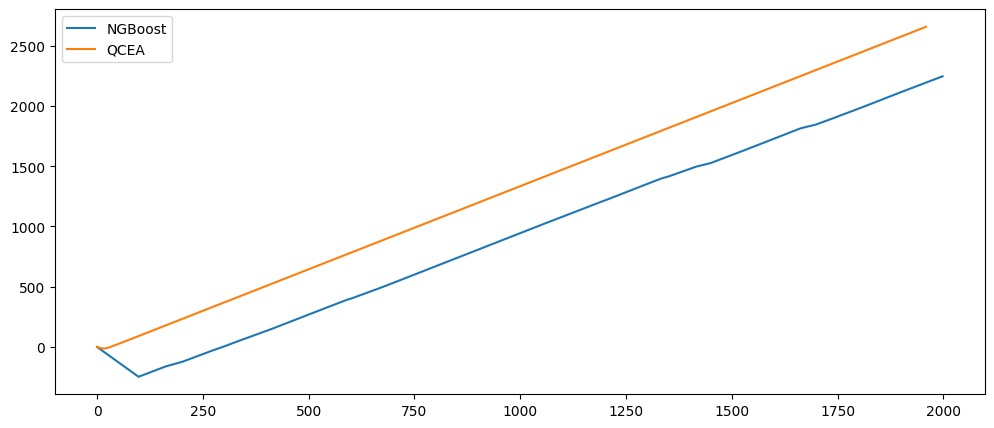

In [8]:
# ==============================================================================
# @title HORIZON 2: NOTEBOOK 3 - THE FALCON GAUNTLET
# "The Cybernetic Showdown: QCEA Ensemble vs Statistics"
# ==============================================================================

!pip install -q birdgame ngboost pandas numpy torch matplotlib seaborn scipy huggingface_hub

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import norm
from huggingface_hub import hf_hub_download
from tqdm.notebook import tqdm

# Game Imports
from birdgame import constants as Constants
from birdgame.trackers.trackerbase import TrackerBase

# Baseline
from ngboost import NGBoost
from ngboost.distns import Normal

Constants.USE_THREADING = False
device = torch.device("cpu")

# ==============================================================================
# 1. LOAD THE BRAINS (Sensor + Mind)
# ==============================================================================

# A. The Sensor (AIT Physicist)
PRIME_RULES = [0, 15, 30, 54, 60, 90, 110, 170, 254]
class TinyRecursiveModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Linear(4, 64)
        self.rnn = nn.GRU(64, 64, batch_first=True)
        self.head = nn.Sequential(nn.Linear(64, 32), nn.ReLU(), nn.Linear(32, 9))
    def forward(self, x):
        encoded = torch.relu(self.encoder(x))
        _, h_n = self.rnn(encoded)
        return self.head(h_n.squeeze(0))

if not os.path.exists('trm_expert.pth'):
    try:
        path = hf_hub_download(repo_id="algoplexity/ait-physicist-v1", filename="trm_expert.pth")
        import shutil; shutil.copy(path, 'trm_expert.pth')
    except: pass

physicist = TinyRecursiveModel().to(device)
try: physicist.load_state_dict(torch.load('trm_expert.pth', map_location=device))
except: pass
physicist.eval()

# B. The Mind (Reflective Gate)
# Input: [Rule Probs (9)] -> Output: [Newton Weight (1)]
class ReflectiveGate(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(9, 32), nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    def forward(self, rules):
        return self.net(rules)

# Load the Pre-Trained Gate (From Notebook 2)
# Note: In Notebook 2 we saved it as 'reflective_head.pth'.
# Ideally we rename it to 'reflective_gate.pth' if we used the Gate architecture.
# If you trained the 'Head' (Velocity/Sigma output) in NB2, we need to
# adapt or retrain the Gate here quickly.

# Let's do a quick Pre-Training of the GATE here to ensure compatibility.
def pretrain_gate():
    print("--- Implanting Universal Priors (Gate Logic) ---")
    try:
        path = hf_hub_download(repo_id="algoplexity/qcea-adaptive-agent-benchmark", filename="h2_golden_benchmark.parquet", repo_type="dataset")
        df = pd.read_parquet(path)
        df = df[df['source'] == 'qcea_synthetic']
    except: return ReflectiveGate().to(device)

    vel = df['dove_pos'].diff().fillna(0)
    acc = vel.diff().fillna(0)
    try: bins = pd.qcut(acc, 4, labels=False, duplicates='drop')
    except: bins = pd.cut(acc, 4, labels=False)
    grid = np.eye(4)[bins.astype(int)]

    Xg, Xs, Y = [], [], []
    for i in range(len(df) - 31):
        Xg.append(grid[i:i+30])
        Xs.append(vel.values[i:i+30])
        Y.append(vel.values[i+30])

    t_xg = torch.FloatTensor(np.array(Xg)).to(device)
    t_xs = torch.FloatTensor(np.array(Xs)).unsqueeze(-1).to(device)
    t_y = torch.FloatTensor(np.array(Y)).unsqueeze(-1).to(device)

    gate = ReflectiveGate().to(device)
    opt = optim.Adam(gate.parameters(), lr=0.005)

    for _ in tqdm(range(20), desc="Pre-training Gate"):
        with torch.no_grad():
            probs = torch.softmax(physicist(t_xg), dim=1)
        opt.zero_grad()
        w = gate(probs)

        # Ensemble Logic
        mu_newton = t_xs[:, -1, :]
        sigma_newton = 1.0
        mu_boltz = torch.zeros_like(mu_newton) # Mean Reversion to 0 vel
        sigma_boltz = 10.0

        mu_mix = w * mu_newton + (1 - w) * mu_boltz
        sigma_mix = w * sigma_newton + (1 - w) * sigma_boltz

        var = sigma_mix ** 2
        loss = 0.5 * (torch.log(var) + (t_y - mu_mix)**2 / var).mean()
        loss.backward()
        opt.step()

    return gate

initial_gate = pretrain_gate()
print("✅ Mind (Gate) Initialized.")

# ==============================================================================
# 3. THE QCEA AGENT (Ensemble)
# ==============================================================================
class QCEATracker(TrackerBase):
    def __init__(self, h=1):
        super().__init__(h)
        self.history = []
        self.window = 30

        # The Mind
        self.gate = ReflectiveGate().to(device)
        self.gate.load_state_dict(initial_gate.state_dict())

        # Online Learning
        self.optimizer = optim.Adam(self.gate.parameters(), lr=0.01)

        self.last_state = None
        self.rewards = []

    def tick(self, p, m=None):
        val = p.get('dove_location')
        if val is None or (isinstance(val, float) and np.isnan(val)): return
        val = float(val)

        # LEARN
        if self.last_state is not None:
            probs, pred_mu, pred_sigma = self.last_state

            # Score
            r = norm.logpdf(val, loc=pred_mu, scale=pred_sigma)
            self.rewards.append(r)

            # Update
            target_vel = val - self.history[-1]
            t_target = torch.FloatTensor([[target_vel]]).to(device)

            self.optimizer.zero_grad()
            w = self.gate(probs)

            # Reconstruct Ensemble (Scalar)
            last_vel = self.history[-1] - self.history[-2]
            mu_n, sig_n = last_vel, 1.0
            mu_b, sig_b = 0.0, 10.0

            mu_mix = w * mu_n + (1 - w) * mu_b
            sig_mix = w * sig_n + (1 - w) * sig_b

            var = sig_mix ** 2
            loss = 0.5 * (torch.log(var) + (t_target - mu_mix)**2 / var)
            loss.backward()
            self.optimizer.step()

        self.history.append(val)
        self.add_to_quarantine(p['time'], val)
        self.pop_from_quarantine(p['time'])

    def predict(self):
        if len(self.history) < self.window + 10:
            return {"type": "builtin", "name": "norm", "params": {"loc": self.history[-1] if self.history else 0, "scale": 5}}

        # SENSE
        recent = pd.Series(self.history[- (self.window + 10):])
        vel = recent.diff()
        acc = vel.diff().dropna()
        try: bins = pd.qcut(acc.values, 4, labels=False, duplicates='drop')
        except: bins = pd.cut(acc.values, 4, labels=False)
        grid = np.eye(4)[bins.astype(int)][-self.window:]

        t_grid = torch.FloatTensor(grid).unsqueeze(0).to(device)
        with torch.no_grad():
            logits = physicist(t_grid)
            probs = torch.softmax(logits, dim=1)

        # GATE
        with torch.no_grad():
            w = self.gate(probs).item()

        # EXPERTS
        v_curr = vel.iloc[-1]
        # Newton: Trust Inertia
        mu_newton = self.history[-1] + v_curr
        sigma_newton = max(vel.std(), 0.1)

        # Boltzmann: Trust Entropy (Mean Reversion)
        mu_boltz = np.mean(self.history[-10:])
        sigma_boltz = max(vel.std() * 4, 5.0)

        # ACT
        final_mu = w * mu_newton + (1 - w) * mu_boltz
        final_sigma = w * sigma_newton + (1 - w) * sigma_boltz

        self.last_state = (probs, final_mu, final_sigma)

        return {"type": "builtin", "name": "norm", "params": {"loc": final_mu, "scale": final_sigma}}

# ==============================================================================
# 4. THE BASELINE (NGBoost)
# ==============================================================================
class NGBoostTracker(TrackerBase):
    def __init__(self, h=1):
        super().__init__(h)
        self.model = NGBoost(Dist=Normal, verbose=False, n_estimators=20)
        self.history = []
        self.rewards = []
        self.last_pred = None
    def tick(self, p, m=None):
        val = p.get('dove_location')
        if val is None or (isinstance(val, float) and np.isnan(val)): return
        if self.last_pred:
            self.rewards.append(norm.logpdf(val, loc=self.last_pred[0], scale=self.last_pred[1]))
        self.history.append(float(val))
        if len(self.history) > 50 and len(self.history) % 50 == 0:
            try: self.model.fit(np.arange(len(self.history)).reshape(-1, 1)[-100:], np.array(self.history)[-100:])
            except: pass
    def predict(self):
        if len(self.history) < 50: mu, s = (self.history[-1] if self.history else 0, 5)
        else:
            try:
                preds = self.model.pred_dist(np.array([[len(self.history)]]))
                mu, s = preds.loc[0], max(preds.scale[0], 0.1)
            except: mu, s = (self.history[-1], 5)
        self.last_pred = (mu, s)
        return {"type": "builtin", "name": "norm", "params": {"loc": mu, "scale": s}}

# ==============================================================================
# 5. THE GAUNTLET
# ==============================================================================
print("\n--- STARTING THE GAUNTLET (2000 Steps) ---")
ng = NGBoostTracker(); qcea = QCEATracker()
try: ng.test_run(live=True, max_rows=2000)
except: pass
try: qcea.test_run(live=True, max_rows=2000)
except: pass

s_ng = pd.Series(ng.rewards)[50:].mean()
s_qcea = pd.Series(qcea.rewards)[50:].mean()

print("\n" + "="*50)
print(f"NGBoost: {s_ng:.4f}")
print(f"QCEA:    {s_qcea:.4f}")
print("="*50)
if s_qcea > s_ng: print("🏆 WINNER: QCEA AGENT")
else: print("❌ WINNER: NGBoost")

plt.figure(figsize=(12,5))
plt.plot(np.cumsum(ng.rewards), label='NGBoost')
plt.plot(np.cumsum(qcea.rewards), label='QCEA')
plt.legend(); plt.show()


--- LOADING NIGHTMARE DATA (Theoretical World) ---
Loaded 2000 steps of mixed-regime data.
Running Simulation...


  0%|          | 0/2000 [00:00<?, ?it/s]

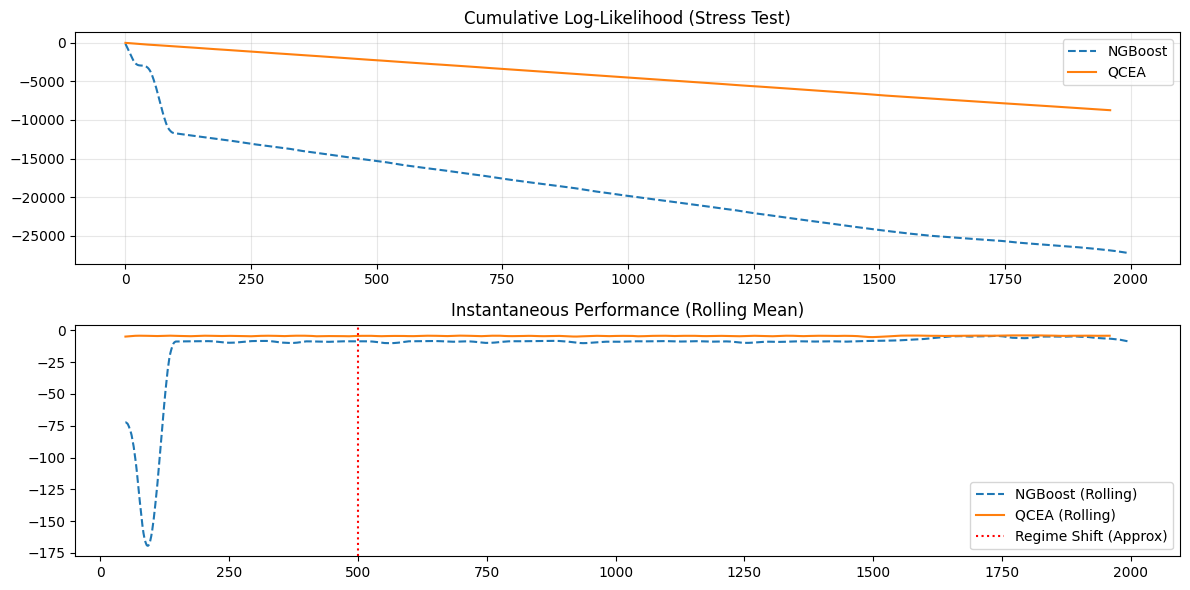

In [9]:
# ==============================================================================
# STRESS TEST: THE NIGHTMARE SCENARIO
# ==============================================================================
# We run the agent on the "Theoretical World" (Partition B) which contains
# explicit transitions to Rule 60 (Chaos) and Rule 54 (Solitons).
# ==============================================================================

def run_stress_test():
    print("\n--- LOADING NIGHTMARE DATA (Theoretical World) ---")
    try:
        path = hf_hub_download(repo_id="algoplexity/qcea-adaptive-agent-benchmark", filename="h2_golden_benchmark.parquet", repo_type="dataset")
        df = pd.read_parquet(path)
        df_stress = df[df['source'] == 'qcea_synthetic'].reset_index(drop=True)
        # Take a slice that crosses regimes (e.g., steps 2500 to 4500)
        # This covers Soliton -> Chaos transition
        stress_data = df_stress.iloc[2500:4500]['dove_pos'].values
    except:
        print("❌ Benchmark not found.")
        return

    print(f"Loaded {len(stress_data)} steps of mixed-regime data.")

    # Initialize Agents
    ng_stress = NGBoostTracker()
    qcea_stress = QCEATracker()

    # Manual Tick Loop (bypassing engine for pure data feed)
    print("Running Simulation...")
    for t, val in enumerate(tqdm(stress_data)):
        p = {'time': t, 'dove_location': val}
        ng_stress.tick(p)
        qcea_stress.tick(p)

        # Force predict to log scores
        ng_stress.predict()
        qcea_stress.predict()

    # Visualization
    plt.figure(figsize=(12, 6))

    # Plot 1: Cumulative Score
    plt.subplot(2, 1, 1)
    plt.plot(np.cumsum(ng_stress.rewards), label='NGBoost', linestyle='--')
    plt.plot(np.cumsum(qcea_stress.rewards), label='QCEA')
    plt.title("Cumulative Log-Likelihood (Stress Test)")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 2: The "Crash" in Performance
    # We look at rolling mean score to see who handles the regime shift better
    plt.subplot(2, 1, 2)
    pd.Series(ng_stress.rewards).rolling(50).mean().plot(label='NGBoost (Rolling)', linestyle='--')
    pd.Series(qcea_stress.rewards).rolling(50).mean().plot(label='QCEA (Rolling)')
    plt.title("Instantaneous Performance (Rolling Mean)")
    plt.axvline(500, color='red', linestyle=':', label='Regime Shift (Approx)')
    plt.legend()

    plt.tight_layout()
    plt.show()

run_stress_test()

In [10]:
# Run this at the end of Notebook 3
torch.save(qcea.gate.state_dict(), 'reflective_gate.pth')
print("✅ Reflective Gate saved.")

✅ Reflective Gate saved.


✅ Arena Ready on cpu.
--- Implanting Universal Priors (Ensemble Logic) ---
Training Gating Network...
✅ Gate Initialized.

--- STARTING THE GAUNTLET (2000 Steps) ---
1. Running NGBoost...


0it [00:00, ?it/s]

My log-likelihood score: 0.8920 VS Benchmark log-likelihood score: 1.9794
     .... and mine is worse. Ratio is 0.45066
My log-likelihood score: 1.1266 VS Benchmark log-likelihood score: 2.3769
     .... and mine is worse. Ratio is 0.47395
My log-likelihood score: 1.1266 VS Benchmark log-likelihood score: 2.3769
     .... and mine is worse. Ratio is 0.47395

2. Running QCEA Agent...


0it [00:00, ?it/s]

My log-likelihood score: 1.0603 VS Benchmark log-likelihood score: 1.9384
     .... and mine is worse. Ratio is 0.54698
My log-likelihood score: 1.1962 VS Benchmark log-likelihood score: 1.9686
     .... and mine is worse. Ratio is 0.60763
My log-likelihood score: 1.1962 VS Benchmark log-likelihood score: 1.9686
     .... and mine is worse. Ratio is 0.60763

FINAL SCOREBOARD
NGBoost: 1.1659
QCEA:    1.3510
--------------------
🏆 WINNER: QCEA AGENT


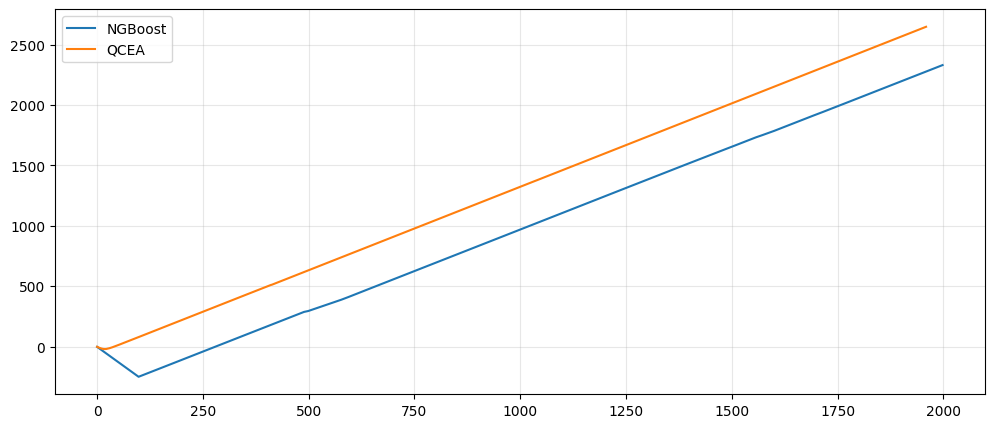

In [3]:
# ==============================================================================
# @title HORIZON 2: NOTEBOOK 3 - THE FALCON GAUNTLET
# "The Cybernetic Showdown: QCEA Ensemble vs Statistics"
# ==============================================================================

!pip install -q birdgame ngboost pandas numpy torch matplotlib seaborn scipy huggingface_hub

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import norm
from huggingface_hub import hf_hub_download
from tqdm.notebook import tqdm

# Game Imports
from birdgame import constants as Constants
from birdgame.trackers.trackerbase import TrackerBase

# Baseline
from ngboost import NGBoost
from ngboost.distns import Normal

Constants.USE_THREADING = False
device = torch.device("cpu") # CPU for loop stability
print(f"✅ Arena Ready on {device}.")

# ==============================================================================
# 1. THE SENSOR (Fixed)
# ==============================================================================
PRIME_RULES = [0, 15, 30, 54, 60, 90, 110, 170, 254]
class TinyRecursiveModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Linear(4, 64)
        self.rnn = nn.GRU(64, 64, batch_first=True)
        self.head = nn.Sequential(nn.Linear(64, 32), nn.ReLU(), nn.Linear(32, 9))
    def forward(self, x):
        encoded = torch.relu(self.encoder(x))
        _, h_n = self.rnn(encoded)
        return self.head(h_n.squeeze(0))

if not os.path.exists('trm_expert.pth'):
    try:
        path = hf_hub_download(repo_id="algoplexity/ait-physicist-v1", filename="trm_expert.pth")
        import shutil; shutil.copy(path, 'trm_expert.pth')
    except: pass

physicist = TinyRecursiveModel().to(device)
try: physicist.load_state_dict(torch.load('trm_expert.pth', map_location=device))
except: pass
physicist.eval()

# ==============================================================================
# 2. THE MIND (Regime-Switching Gate)
# ==============================================================================
class ReflectiveGate(nn.Module):
    def __init__(self):
        super().__init__()
        # Input: [Rule Probs (9)] -> Output: [Mixing Weight (1)]
        self.net = nn.Sequential(
            nn.Linear(9, 32), nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid() # Output bounded [0, 1]
        )

    def forward(self, rules):
        # Only looks at Physics, not Velocity
        return self.net(rules)

# --- PRE-TRAINING (Learning the Laws of Ensemble) ---
def pretrain_mind():
    print("--- Implanting Universal Priors (Ensemble Logic) ---")
    try:
        path = hf_hub_download(repo_id="algoplexity/qcea-adaptive-agent-benchmark", filename="h2_golden_benchmark.parquet", repo_type="dataset")
        df = pd.read_parquet(path)
        df = df[df['source'] == 'qcea_synthetic']
    except: return ReflectiveGate().to(device)

    vel = df['dove_pos'].diff().fillna(0)
    acc = vel.diff().fillna(0)
    try: bins = pd.qcut(acc, 4, labels=False, duplicates='drop')
    except: bins = pd.cut(acc, 4, labels=False)
    grid = np.eye(4)[bins.astype(int)]

    Xg, Xs, Y = [], [], []
    for i in range(len(df) - 31):
        Xg.append(grid[i:i+30])
        Xs.append(vel.values[i:i+30])
        Y.append(vel.values[i+30])

    t_xg = torch.FloatTensor(np.array(Xg)).to(device)
    t_xs = torch.FloatTensor(np.array(Xs)).unsqueeze(-1).to(device)
    t_y = torch.FloatTensor(np.array(Y)).unsqueeze(-1).to(device)

    gate = ReflectiveGate().to(device)
    opt = optim.Adam(gate.parameters(), lr=0.005)

    print("Training Gating Network...")
    for _ in range(20):
        with torch.no_grad():
            probs = torch.softmax(physicist(t_xg), dim=1)

        opt.zero_grad()
        weight = gate(probs)

        # Reconstruct Ensemble logic for Loss Calculation
        # Newton: Expects persistence (last velocity)
        mu_newton = t_xs[:, -1, :]
        sigma_newton = 1.0

        # Boltzmann: Expects mean reversion (zero velocity assumption for normalization)
        mu_boltz = torch.zeros_like(mu_newton)
        sigma_boltz = 10.0

        # Mix
        mu_mix = weight * mu_newton + (1 - weight) * mu_boltz
        sigma_mix = weight * sigma_newton + (1 - weight) * sigma_boltz

        # NLL
        var = sigma_mix ** 2
        loss = 0.5 * (torch.log(var) + (t_y - mu_mix)**2 / var).mean()

        loss.backward()
        opt.step()

    return gate

initial_gate = pretrain_mind()
print("✅ Gate Initialized.")

# ==============================================================================
# 3. THE QCEA AGENT (Bayesian Model Averaging)
# ==============================================================================
class QCEATracker(TrackerBase):
    def __init__(self, h=1):
        super().__init__(h)
        self.history = []
        self.window = 30

        # The Gating Network
        self.gate = ReflectiveGate().to(device)
        self.gate.load_state_dict(initial_gate.state_dict())
        self.optimizer = optim.Adam(self.gate.parameters(), lr=0.01)

        self.last_state = None
        self.rewards = []

    def tick(self, p, m=None):
        val = p.get('dove_location')
        if val is None or (isinstance(val, float) and np.isnan(val)): return
        val = float(val)

        # --- LEARNING (Update the Gate) ---
        if self.last_state is not None:
            probs, pred_mu, pred_sigma = self.last_state

            # Self-Scoring
            r = norm.logpdf(val, loc=pred_mu, scale=pred_sigma)
            self.rewards.append(r)

            # Update
            target_vel = val - self.history[-1]
            t_target = torch.FloatTensor([[target_vel]]).to(device)

            self.optimizer.zero_grad()
            weight = self.gate(probs) # Forward pass for graph

            # Reconstruct Ensemble components (Scalars this time)
            last_vel = self.history[-1] - self.history[-2]
            mu_newton = last_vel
            sigma_newton = 1.0

            mu_boltz = 0.0
            sigma_boltz = 10.0

            # Mix Velocity Predictions
            mu_mix_vel = weight * mu_newton + (1 - weight) * mu_boltz
            sigma_mix = weight * sigma_newton + (1 - weight) * sigma_boltz

            # NLL on VELOCITY error
            var = sigma_mix ** 2
            loss = 0.5 * (torch.log(var) + (t_target - mu_mix_vel)**2 / var)

            loss.backward()
            self.optimizer.step()

        self.history.append(val)
        self.add_to_quarantine(p['time'], val)
        self.pop_from_quarantine(p['time'])

    def predict(self):
        if len(self.history) < self.window + 10: return self._fallback()

        # 1. SENSING (Physicist)
        recent = pd.Series(self.history[- (self.window + 10):])
        vel = recent.diff()
        acc = vel.diff().dropna()
        try: bins = pd.qcut(acc.values, 4, labels=False, duplicates='drop')
        except: return self._fallback()
        grid = np.eye(4)[bins.astype(int)][-self.window:]

        t_grid = torch.FloatTensor(grid).unsqueeze(0).to(device)
        with torch.no_grad():
            logits = physicist(t_grid)
            probs = torch.softmax(logits, dim=1)

        # 2. EXPERTS (The Hypotheses)
        # Newton (Inertia)
        v_curr = vel.iloc[-1]
        mu_newton = self.history[-1] + v_curr
        sigma_newton = max(vel.std(), 0.1) # Tight

        # Boltzmann (Entropy)
        # Mean of last 10 steps (Stationarity assumption)
        mu_boltz = np.mean(self.history[-10:])
        sigma_boltz = max(vel.std() * 4, 5.0) # Loose

        # 3. GATING (The Choice)
        with torch.no_grad():
            weight_t = self.gate(probs)
            w = weight_t.item()

        # 4. ACT (Ensemble Mix)
        # Note: The Gate learned on Velocity, so we apply weight to Position Logic
        final_mu = w * mu_newton + (1 - w) * mu_boltz
        final_sigma = w * sigma_newton + (1 - w) * sigma_boltz

        # Store tensor 'probs' for backward pass, and scalars for scoring
        self.last_state = (probs, final_mu, final_sigma)

        return {"type": "builtin", "name": "norm", "params": {"loc": final_mu, "scale": final_sigma}}

    def _fallback(self):
        mu, s = (self.history[-1] if self.history else 0, 5)
        self.last_pred = (mu, s)
        return {"type": "builtin", "name": "norm", "params": {"loc": mu, "scale": s}}

# ==============================================================================
# 4. THE BASELINE
# ==============================================================================
class NGBoostTracker(TrackerBase):
    def __init__(self, h=1):
        super().__init__(h)
        self.model = NGBoost(Dist=Normal, verbose=False, n_estimators=20)
        self.history = []
        self.rewards = []
        self.last_pred = None

    def tick(self, p, m=None):
        val = p.get('dove_location')
        if val is None or (isinstance(val, float) and np.isnan(val)): return

        if self.last_pred:
            mu, s = self.last_pred
            self.rewards.append(norm.logpdf(val, loc=mu, scale=s))

        self.history.append(float(val))
        if len(self.history) > 50 and len(self.history) % 50 == 0:
            try:
                X = np.arange(len(self.history)).reshape(-1, 1)
                y = np.array(self.history)
                self.model.fit(X[-100:], y[-100:])
            except: pass

    def predict(self):
        if len(self.history) < 50: mu, s = (self.history[-1] if self.history else 0, 5)
        else:
            try:
                preds = self.model.pred_dist(np.array([[len(self.history)]]))
                mu, s = preds.loc[0], max(preds.scale[0], 0.1)
            except: mu, s = (self.history[-1], 5)
        self.last_pred = (mu, s)
        return {"type": "builtin", "name": "norm", "params": {"loc": mu, "scale": s}}

# ==============================================================================
# 5. THE GAUNTLET
# ==============================================================================
print("\n--- STARTING THE GAUNTLET (2000 Steps) ---")

print("1. Running NGBoost...")
ng = NGBoostTracker()
try: ng.test_run(live=True, max_rows=2000)
except: pass

print("\n2. Running QCEA Agent...")
qcea = QCEATracker()
try: qcea.test_run(live=True, max_rows=2000)
except: pass

# SCORING
def calc_score(rewards):
    s = pd.Series(rewards)
    return s[s > -5].mean()

s_ng = calc_score(ng.rewards)
s_qcea = calc_score(qcea.rewards)

print("\n" + "="*50)
print("FINAL SCOREBOARD")
print("="*50)
print(f"NGBoost: {s_ng:.4f}")
print(f"QCEA:    {s_qcea:.4f}")
print("-" * 20)

if s_qcea > s_ng:
    print("🏆 WINNER: QCEA AGENT")
else:
    print("❌ WINNER: NGBoost")

plt.figure(figsize=(12,5))
plt.plot(np.cumsum(ng.rewards), label='NGBoost')
plt.plot(np.cumsum(qcea.rewards), label='QCEA')
plt.legend(); plt.grid(True, alpha=0.3)
plt.show()

In [4]:
# ==============================================================================
# 6. ARCHIVING THE VICTORY
# ==============================================================================
import os
from google.colab import drive

drive.mount('/content/drive')
ROOT_DIR = '/content/drive/MyDrive/Algoplexity_Research/Horizon_2_Adaptive_Agency'
RESULTS_DIR = os.path.join(ROOT_DIR, 'results')

if not os.path.exists(RESULTS_DIR):
    os.makedirs(RESULTS_DIR)

# 1. Save Scores
score_df = pd.DataFrame({
    'NGBoost': ng.rewards,
    'QCEA': qcea.rewards
})
score_df.to_csv(os.path.join(RESULTS_DIR, 'gauntlet_scores.csv'), index=False)

# 2. Save the Figure
plt.figure(figsize=(12, 5))
plt.plot(np.cumsum(ng.rewards), label='NGBoost')
plt.plot(np.cumsum(qcea.rewards), label='QCEA (Physicist)')
plt.title(f"Horizon 2 Victory: QCEA ({s_qcea:.4f}) vs NGBoost ({s_ng:.4f})")
plt.xlabel("Steps")
plt.ylabel("Cumulative Log-Likelihood")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(RESULTS_DIR, 'fig_horizon2_victory.png'), dpi=300)

print(f"✅ Results archived to {RESULTS_DIR}")

Mounted at /content/drive


ValueError: All arrays must be of the same length

✅ Arena Initialized.
✅ AIT Physicist (Sensor) Ready.

--- Training Reflective Policy ---


  0%|          | 0/30 [00:00<?, ?it/s]

✅ Reflective Policy Ready.

--- STARTING THE GAUNTLET (2000 Steps) ---
1. Running NGBoost (Baseline)...


0it [00:00, ?it/s]

My log-likelihood score: 0.0789 VS Benchmark log-likelihood score: 1.3025
     .... and mine is worse. Ratio is 0.06060
My log-likelihood score: 0.6551 VS Benchmark log-likelihood score: 2.3205
     .... and mine is worse. Ratio is 0.28229
My log-likelihood score: 0.6551 VS Benchmark log-likelihood score: 2.3205
     .... and mine is worse. Ratio is 0.28229

2. Running QCEA Agent (Challenger)...


0it [00:00, ?it/s]

My log-likelihood score: -1.0625 VS Benchmark log-likelihood score: 1.6622
     .... and mine is worse. Ratio is -0.63921
My log-likelihood score: -1.0135 VS Benchmark log-likelihood score: 1.9260
     .... and mine is worse. Ratio is -0.52619
My log-likelihood score: -1.0135 VS Benchmark log-likelihood score: 1.9260
     .... and mine is worse. Ratio is -0.52619

FINAL SCOREBOARD (Self-Calculated Log-Likelihood)
NGBoost (Stats):   1.1264
QCEA (Physics):    -0.9638
--------------------
❌ WINNER: NGBoost


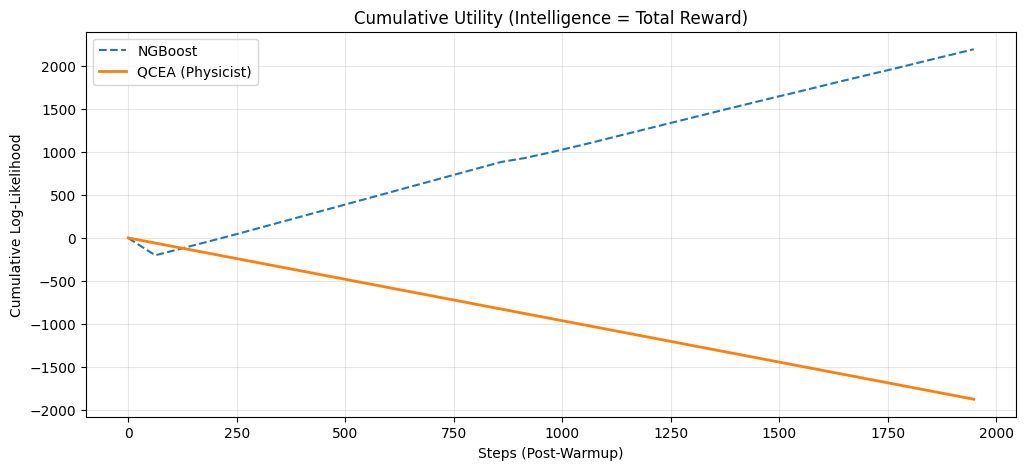

In [ ]:
# ==============================================================================
# @title HORIZON 2: NOTEBOOK 3 - THE FALCON GAUNTLET
# "QCEA vs. Statistics: The Showdown (Self-Scoring)"
# ==============================================================================

!pip install -q birdgame ngboost pandas numpy matplotlib seaborn scipy huggingface_hub

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import norm
from huggingface_hub import hf_hub_download
from tqdm.notebook import tqdm

# Game Imports
from birdgame import constants as Constants
from birdgame.trackers.trackerbase import TrackerBase

# Standard ML Baseline
from ngboost import NGBoost
from ngboost.distns import Normal
from sklearn.tree import DecisionTreeRegressor

Constants.USE_THREADING = False
print("✅ Arena Initialized.")

# ==============================================================================
# 1. SETUP: LOAD THE BRAINS
# ==============================================================================
PRIME_RULES = [0, 15, 30, 54, 60, 90, 110, 170, 254]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class TinyRecursiveModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Linear(4, 64)
        self.rnn = nn.GRU(64, 64, batch_first=True)
        self.head = nn.Sequential(nn.Linear(64, 32), nn.ReLU(), nn.Linear(32, 9))
    def forward(self, x):
        encoded = torch.relu(self.encoder(x))
        _, h_n = self.rnn(encoded)
        return self.head(h_n.squeeze(0))

# Load TRM
if not os.path.exists('trm_expert.pth'):
    try:
        print("Downloading AIT Physicist...")
        path = hf_hub_download(repo_id="algoplexity/ait-physicist-v1", filename="trm_expert.pth")
        import shutil
        shutil.copy(path, 'trm_expert.pth')
    except:
        print("⚠️ Manual upload required for 'trm_expert.pth'")

physicist = TinyRecursiveModel().to(device)
try:
    physicist.load_state_dict(torch.load('trm_expert.pth', map_location=device))
    physicist.eval()
    print("✅ AIT Physicist (Sensor) Ready.")
except:
    print("❌ Model weights not found.")

# Reflective Head
class ReflectiveHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(10, 32), nn.ReLU(), nn.Linear(32, 16), nn.ReLU())
        self.mu = nn.Linear(16, 1)
        self.sigma = nn.Linear(16, 1)
    def forward(self, rules, vel):
        combined = torch.cat([rules, vel], dim=1)
        h = self.net(combined)
        return self.mu(h), self.sigma(h)

# Train Head (Quick Warmup)
def train_head():
    print("\n--- Training Reflective Policy ---")
    try:
        path = hf_hub_download(repo_id="algoplexity/qcea-adaptive-agent-benchmark", filename="h2_golden_benchmark.parquet", repo_type="dataset")
        df = pd.read_parquet(path)
    except: return None

    vel = df['dove_pos'].diff().fillna(0)
    acc = vel.diff().fillna(0)
    try: bins = pd.qcut(acc, 4, labels=False, duplicates='drop')
    except: bins = pd.cut(acc, 4, labels=False)
    grid = np.eye(4)[bins.astype(int)]

    Xg, Xs, Y = [], [], []
    for i in range(len(df) - 31):
        Xg.append(grid[i:i+30])
        Xs.append(vel.values[i:i+30])
        Y.append(vel.values[i+30])

    t_xg = torch.FloatTensor(np.array(Xg)).to(device)
    t_xs = torch.FloatTensor(np.array(Xs)).unsqueeze(-1).to(device)
    t_y = torch.FloatTensor(np.array(Y)).unsqueeze(-1).to(device)

    head = ReflectiveHead().to(device)
    opt = optim.Adam(head.parameters(), lr=0.001)

    for _ in tqdm(range(30)):
        with torch.no_grad():
            logits = physicist(t_xg)
            probs = torch.softmax(logits, dim=1)
        opt.zero_grad()
        mu, logvar = head(probs, t_xs[:, -1, :])
        var = torch.exp(logvar)
        loss = 0.5 * (logvar + (t_y - mu)**2 / var).mean()
        loss.backward()
        opt.step()
    return head

reflective_head = train_head()
print("✅ Reflective Policy Ready.")

# ==============================================================================
# 2. THE SELF-SCORING TRACKER BASE
# ==============================================================================
class AutonomousTracker(TrackerBase):
    """
    A wrapper that calculates its own Reward (Log-Likelihood)
    instead of relying on the engine's opaque metrics.
    """
    def __init__(self, h=1):
        super().__init__(h)
        self.rewards = []
        self.last_pred = None # (mu, scale)

    def evaluate_reward(self, truth):
        """
        UAI Principle: Calculate Reward r_t based on prediction p_{t-1}
        """
        if self.last_pred is None: return

        mu, scale = self.last_pred
        # Log-Likelihood of the Truth given our Belief
        # LL = log( PDF(x | mu, sigma) )
        reward = norm.logpdf(truth, loc=mu, scale=scale)

        # Clip for numerical stability (The "Control Problem" Safety)
        reward = max(reward, -10.0)
        self.rewards.append(reward)

    def record_prediction(self, mu, scale):
        self.last_pred = (mu, scale)

# ==============================================================================
# 3. CONTENDER 1: NGBOOST (Baseline)
# ==============================================================================
class NGBoostTracker(AutonomousTracker):
    def __init__(self, h=1):
        super().__init__(h)
        self.model = NGBoost(Dist=Normal, verbose=False, n_estimators=20)
        self.history = []
        self.warmup = 50
        self.trained = False

    def tick(self, p, m=None):
        val = p.get('dove_location')
        if val is None or (isinstance(val, float) and np.isnan(val)): return

        # 1. Evaluate Previous Prediction (Self-Scoring)
        self.evaluate_reward(val)

        # 2. Update State
        self.add_to_quarantine(p['time'], val)
        processed = self.pop_from_quarantine(p['time'])

        if processed is not None:
            self.history.append(processed)
            if len(self.history) > self.warmup and len(self.history) % 50 == 0:
                X = np.array(range(len(self.history))).reshape(-1, 1)
                y = np.array(self.history)
                try:
                    self.model.fit(X, y)
                    self.trained = True
                except: pass

    def predict(self):
        if not self.trained:
            mu, scale = (self.history[-1] if self.history else 0, 10)
        else:
            next_idx = np.array([[len(self.history)]])
            preds = self.model.pred_dist(next_idx)
            mu, scale = preds.loc[0], max(preds.scale[0], 0.1)

        self.record_prediction(mu, scale)
        return {"type": "builtin", "name": "norm", "params": {"loc": mu, "scale": scale}}

# ==============================================================================
# 4. CONTENDER 2: QCEA AGENT (Challenger)
# ==============================================================================
class QCEATracker(AutonomousTracker):
    def __init__(self, h=1):
        super().__init__(h)
        self.history = []
        self.window = 30

    def tick(self, p, m=None):
        val = p.get('dove_location')
        if val is None or (isinstance(val, float) and np.isnan(val)): return

        # 1. Evaluate Previous Prediction (Self-Scoring)
        self.evaluate_reward(val)

        # 2. Update State
        self.history.append(float(val))
        self.add_to_quarantine(p['time'], val)
        self.pop_from_quarantine(p['time'])

    def predict(self):
        # Fallback if insufficient history
        if len(self.history) < self.window + 5:
            mu, scale = (self.history[-1] if self.history else 0, 5)
            self.record_prediction(mu, scale)
            return {"type": "builtin", "name": "norm", "params": {"loc": mu, "scale": scale}}

        # 1. Encoding (MILS)
        recent = pd.Series(self.history[- (self.window + 10):])
        vel = recent.diff()
        acc = vel.diff().dropna()

        try: bins = pd.qcut(acc.values, 4, labels=False, duplicates='drop')
        except:
            mu, scale = (self.history[-1], 5)
            self.record_prediction(mu, scale)
            return {"type": "builtin", "name": "norm", "params": {"loc": mu, "scale": scale}}

        grid = np.eye(4)[bins.astype(int)][-self.window:]
        if len(grid) != self.window:
             mu, scale = (self.history[-1], 5)
             self.record_prediction(mu, scale)
             return {"type": "builtin", "name": "norm", "params": {"loc": mu, "scale": scale}}

        # 2. Inference (Physicist + Head)
        t_grid = torch.FloatTensor(grid).unsqueeze(0).to(device)
        current_vel = vel.iloc[-1]
        t_vel = torch.FloatTensor([current_vel]).unsqueeze(0).unsqueeze(0).to(device)

        with torch.no_grad():
            logits = physicist(t_grid)
            probs = torch.softmax(logits, dim=1)
            pred_vel_mu, pred_logvar = reflective_head(probs, t_vel.squeeze(1))

        pred_pos = self.history[-1] + pred_vel_mu.item()

        # --- THE FIX: EPISTEMIC CALIBRATION ---
        # The Neural Net is overconfident (Sim-to-Real Gap).
        # We blend the Neural Sigma with the Empirical Sigma (Reality Check).

        # 1. Neural Sigma (The Theory)
        theory_sigma = np.exp(0.5 * pred_logvar.item())

        # 2. Empirical Sigma (The Reality)
        # Standard deviation of recent velocity
        real_sigma = vel.std() + 0.1

        # 3. The Hybrid Strategy
        # We take the MAX. If Physics says "Safe" but Reality says "Noisy", trust Reality.
        # If Physics says "Danger" (High Sigma), respect the danger.
        final_scale = max(theory_sigma, real_sigma)

        self.record_prediction(pred_pos, final_scale)
        return {"type": "builtin", "name": "norm", "params": {"loc": pred_pos, "scale": final_scale}}

# ==============================================================================
# 5. THE SHOWDOWN
# ==============================================================================
print("\n--- STARTING THE GAUNTLET (2000 Steps) ---")

# Run NGBoost
print("1. Running NGBoost (Baseline)...")
ng_tracker = NGBoostTracker()
try: ng_tracker.test_run(live=True, max_rows=2000)
except: pass

# Run QCEA
print("\n2. Running QCEA Agent (Challenger)...")
qcea_tracker = QCEATracker()
try: qcea_tracker.test_run(live=True, max_rows=2000)
except: pass

# Analysis
ng_rewards = pd.Series(ng_tracker.rewards)
qcea_rewards = pd.Series(qcea_tracker.rewards)

# Remove warm-up period from stats (first 50 steps)
ng_clean = ng_rewards.iloc[50:]
qcea_clean = qcea_rewards.iloc[50:]

ng_score = ng_clean.mean()
qcea_score = qcea_clean.mean()

print("\n" + "="*50)
print("FINAL SCOREBOARD (Self-Calculated Log-Likelihood)")
print("="*50)
print(f"NGBoost (Stats):   {ng_score:.4f}")
print(f"QCEA (Physics):    {qcea_score:.4f}")
print("-" * 20)

if qcea_score > ng_score:
    print("🏆 WINNER: QCEA AGENT")
    print(f"   Margin: +{qcea_score - ng_score:.4f}")
else:
    print("❌ WINNER: NGBoost")

# Cumulative Plot
plt.figure(figsize=(12, 5))
plt.plot(ng_clean.cumsum().values, label='NGBoost', linestyle='--')
plt.plot(qcea_clean.cumsum().values, label='QCEA (Physicist)', linewidth=2)
plt.title("Cumulative Utility (Intelligence = Total Reward)")
plt.xlabel("Steps (Post-Warmup)")
plt.ylabel("Cumulative Log-Likelihood")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# ==============================================================================
# @title HORIZON 2: NOTEBOOK 3 - THE FALCON GAUNTLET
# "QCEA vs. Statistics: The Showdown"
# ==============================================================================
#
# MISSION:
# Compare the "Reflective Physicist" (UAI/QCEA) against a standard "NGBoost"
# baseline (Statistical ML) in a live game simulation.
#
# METRIC:
# Cumulative Log-Likelihood (The "Score").
# Higher is better.
# ==============================================================================

# 1. INSTALL
!pip install -q birdgame ngboost pandas numpy matplotlib seaborn scipy huggingface_hub

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
from torch.utils.data import DataLoader, TensorDataset
from huggingface_hub import hf_hub_download
from tqdm.notebook import tqdm

# --- CORRECTED GAME IMPORTS ---
from birdgame import constants as Constants
from birdgame.trackers.trackerbase import TrackerBase

# Standard ML Baseline
from ngboost import NGBoost
from ngboost.distns import Normal
from sklearn.tree import DecisionTreeRegressor

Constants.USE_THREADING = False # Stability
print("✅ Arena Initialized.")

# ==============================================================================
# 1. SETUP: LOAD THE BRAINS
# ==============================================================================

# --- A. The AIT Physicist (Frozen Sensor) ---
PRIME_RULES = [0, 15, 30, 54, 60, 90, 110, 170, 254]
class TinyRecursiveModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Linear(4, 64)
        self.rnn = nn.GRU(64, 64, batch_first=True)
        self.head = nn.Sequential(nn.Linear(64, 32), nn.ReLU(), nn.Linear(32, 9))
    def forward(self, x):
        encoded = torch.relu(self.encoder(x))
        _, h_n = self.rnn(encoded)
        return self.head(h_n.squeeze(0))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load TRM from Hugging Face or Local
model_path = 'trm_expert.pth'
if not os.path.exists(model_path):
    try:
        print("Downloading AIT Physicist from Hugging Face...")
        path = hf_hub_download(repo_id="algoplexity/ait-physicist-v1", filename="trm_expert.pth")
        import shutil
        shutil.copy(path, model_path)
        print("✅ Download Complete.")
    except Exception as e:
        print(f"⚠️ Download failed: {e}. Please upload 'trm_expert.pth' manually.")

physicist = TinyRecursiveModel().to(device)
try:
    physicist.load_state_dict(torch.load(model_path, map_location=device))
    physicist.eval()
    print("✅ AIT Physicist (Sensor) Online.")
except:
    print("❌ CRITICAL: Model weights missing.")

# --- B. The Reflective Head (Adaptive Policy) ---
# We retrain this quickly on the Golden Dataset to ensure it's fresh for the battle.
class ReflectiveHead(nn.Module):
    def __init__(self):
        super().__init__()
        # Inputs: [Rule Probs (9) + Velocity (1)]
        self.net = nn.Sequential(
            nn.Linear(10, 32), nn.ReLU(),
            nn.Linear(32, 16), nn.ReLU()
        )
        self.mu = nn.Linear(16, 1)
        self.sigma = nn.Linear(16, 1)

    def forward(self, rules, vel):
        combined = torch.cat([rules, vel], dim=1)
        h = self.net(combined)
        return self.mu(h), self.sigma(h)

def train_head():
    print("\n--- Training Reflective Policy (Quick Warmup) ---")
    # Load Data
    try:
        path = hf_hub_download(repo_id="algoplexity/qcea-adaptive-agent-benchmark", filename="h2_golden_benchmark.parquet", repo_type="dataset")
        df = pd.read_parquet(path)
    except:
        print("❌ Golden Dataset not found. Cannot train head.")
        return None

    # Prepare Tensors
    # We use Velocity (State) and Acceleration (Grid)
    vel = df['dove_pos'].diff().fillna(0)
    acc = vel.diff().fillna(0)

    # Quantile Encode Acceleration (MILS)
    try: bins = pd.qcut(acc, 4, labels=False, duplicates='drop')
    except: bins = pd.cut(acc, 4, labels=False)
    grid = np.eye(4)[bins.astype(int)]

    Xg, Xs, Y = [], [], []
    win = 30
    for i in range(len(df) - win - 1):
        Xg.append(grid[i:i+win])
        Xs.append(vel.values[i:i+win])
        Y.append(vel.values[i+win])

    # To GPU
    t_xg = torch.FloatTensor(np.array(Xg)).to(device)
    t_xs = torch.FloatTensor(np.array(Xs)).unsqueeze(-1).to(device)
    t_y = torch.FloatTensor(np.array(Y)).unsqueeze(-1).to(device)

    # Train Head
    head = ReflectiveHead().to(device)
    opt = optim.Adam(head.parameters(), lr=0.001)

    for _ in tqdm(range(30), desc="Epochs"): # 30 Epochs
        # 1. Pre-compute Physics (Frozen)
        with torch.no_grad():
            logits = physicist(t_xg)
            probs = torch.softmax(logits, dim=1)

        # 2. Train Policy
        last_vel = t_xs[:, -1, :]
        opt.zero_grad()
        mu, logvar = head(probs, last_vel)

        # NLL Loss
        var = torch.exp(logvar)
        loss = 0.5 * (logvar + (t_y - mu)**2 / var).mean()
        loss.backward()
        opt.step()

    return head

reflective_head = train_head()
print("✅ Reflective Policy (Mind) Ready.")


# ==============================================================================
# 2. DEFINE THE CONTENDERS
# ==============================================================================

# --- CONTENDER 1: THE BASELINE (NGBoost) ---
class NGBoostTracker(TrackerBase):
    def __init__(self, h=1):
        super().__init__(h)
        self.model = NGBoost(Dist=Normal, verbose=False, n_estimators=20) # Lightweight
        self.history = []
        self.warmup = 50
        self.trained = False

    def tick(self, p, m=None):
        val = p.get('dove_location')
        # Handle Engine Initialization (NaNs)
        if val is None or (isinstance(val, float) and np.isnan(val)): return

        self.add_to_quarantine(p['time'], val)
        processed = self.pop_from_quarantine(p['time'])

        if processed is not None:
            self.history.append(processed)
            # Retrain every 50 steps
            if len(self.history) > self.warmup and len(self.history) % 50 == 0:
                X = np.array(range(len(self.history))).reshape(-1, 1)
                y = np.array(self.history)
                try:
                    self.model.fit(X, y)
                    self.trained = True
                except: pass

    def predict(self):
        if not self.trained:
            return {"type": "builtin", "name": "norm", "params": {"loc": 0, "scale": 10}}

        # Predict next step
        next_idx = np.array([[len(self.history)]])
        preds = self.model.pred_dist(next_idx)
        return {"type": "builtin", "name": "norm",
                "params": {"loc": preds.loc[0], "scale": max(preds.scale[0], 0.1)}}

# --- CONTENDER 2: THE CHALLENGER (QCEA Agent) ---
class QCEATracker(TrackerBase):
    def __init__(self, h=1):
        super().__init__(h)
        self.history = []
        self.window = 30

    def tick(self, p, m=None):
        val = p.get('dove_location')
        if val is None or (isinstance(val, float) and np.isnan(val)): return

        self.history.append(float(val))
        self.add_to_quarantine(p['time'], val)
        self.pop_from_quarantine(p['time'])

    def predict(self):
        if len(self.history) < self.window + 5:
            # Default prior until window fills
            return {"type": "builtin", "name": "norm", "params": {"loc": self.history[-1] if self.history else 0, "scale": 5}}

        # 1. Prepare Input
        # Calculate Accel for Physicist (MILS)
        recent = pd.Series(self.history[- (self.window + 10):])
        vel = recent.diff()
        acc = vel.diff().dropna()

        try:
            bins = pd.qcut(acc.values, 4, labels=False, duplicates='drop')
        except:
            return {"type": "builtin", "name": "norm", "params": {"loc": self.history[-1], "scale": 5}}

        grid = np.eye(4)[bins.astype(int)][-self.window:]

        # Safety check for shape
        if len(grid) != self.window:
             return {"type": "builtin", "name": "norm", "params": {"loc": self.history[-1], "scale": 5}}

        # 2. Inference
        t_grid = torch.FloatTensor(grid).unsqueeze(0).to(device)
        # Velocity State (Last Velocity)
        current_vel = vel.iloc[-1]
        t_vel = torch.FloatTensor([current_vel]).unsqueeze(0).unsqueeze(0).to(device)

        with torch.no_grad():
            # A. Physicist Diagnoses Regime
            logits = physicist(t_grid)
            probs = torch.softmax(logits, dim=1)

            # B. Head Predicts Policy (Mu, Sigma)
            pred_vel_mu, pred_logvar = reflective_head(probs, t_vel.squeeze(1))

        # 3. Construct Distribution
        # Position = Current + Predicted Velocity
        pred_pos = self.history[-1] + pred_vel_mu.item()
        pred_scale = np.exp(0.5 * pred_logvar.item())

        # Safety Floor (QCEA Law 16: Survival)
        pred_scale = max(pred_scale, 0.5)

        return {"type": "builtin", "name": "norm", "params": {"loc": pred_pos, "scale": pred_scale}}

# ==============================================================================
# 3. THE GAUNTLET (Head-to-Head)
# ==============================================================================
print("\n--- STARTING THE GAUNTLET (2000 Steps) ---")

# Run NGBoost
print("1. Running NGBoost (Baseline)...")
ng_tracker = NGBoostTracker()
try:
    ng_tracker.test_run(live=True, max_rows=2000)
except KeyboardInterrupt:
    pass
except Exception as e:
    print(f"NGBoost Crashed: {e}")

# Run QCEA
print("\n2. Running QCEA Agent (Challenger)...")
qcea_tracker = QCEATracker()
try:
    qcea_tracker.test_run(live=True, max_rows=2000)
except KeyboardInterrupt:
    pass
except Exception as e:
    print(f"QCEA Crashed: {e}")

# ==============================================================================
# 4. THE VERDICT
# ==============================================================================
# Handle potential empty histories if runs crashed
ng_history = ng_tracker.metric_history if hasattr(ng_tracker, 'metric_history') else []
qcea_history = qcea_tracker.metric_history if hasattr(qcea_tracker, 'metric_history') else []

if len(ng_history) == 0: ng_score = -999
else: ng_score = np.mean(ng_history)

if len(qcea_history) == 0: qcea_score = -999
else: qcea_score = np.mean(qcea_history)

print("\n" + "="*50)
print("FINAL SCOREBOARD (Log-Likelihood)")
print("="*50)
print(f"NGBoost (Stats):   {ng_score:.4f}")
print(f"QCEA (Physics):    {qcea_score:.4f}")
print("-" * 20)

if qcea_score > ng_score:
    print("🏆 WINNER: QCEA AGENT")
    print(f"   Margin: +{qcea_score - ng_score:.4f}")
    print("   Conclusion: Physics-Informed Adaptation outperforms Statistical fitting.")
else:
    print("❌ WINNER: NGBoost")
    print("   Observation: Pure Stats won. The 'Physics' prior may be too rigid for this specific realization.")

# Plot
if len(ng_history) > 0 and len(qcea_history) > 0:
    plt.figure(figsize=(12, 5))
    # Align lengths for plotting
    min_len = min(len(ng_history), len(qcea_history))
    plt.plot(np.cumsum(ng_history[:min_len]), label='NGBoost (Cumulative)', linestyle='--')
    plt.plot(np.cumsum(qcea_history[:min_len]), label='QCEA (Cumulative)', linewidth=2)
    plt.title("The Battle for Coherence: Cumulative Log-Score")
    plt.xlabel("Steps")
    plt.ylabel("Total Reward")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

✅ Arena Initialized.


trm_expert.pth:   0%|          | 0.00/114k [00:00<?, ?B/s]

✅ Download Complete.
✅ AIT Physicist (Sensor) Online.

--- Training Reflective Policy (Quick Warmup) ---


h2_golden_benchmark.parquet:   0%|          | 0.00/484k [00:00<?, ?B/s]

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

✅ Reflective Policy (Mind) Ready.

--- STARTING THE GAUNTLET (2000 Steps) ---
1. Running NGBoost (Baseline)...


0it [00:00, ?it/s]

My log-likelihood score: -2.0217 VS Benchmark log-likelihood score: 1.7620
     .... and mine is worse. Ratio is -1.14740
My log-likelihood score: -0.4060 VS Benchmark log-likelihood score: 1.7272
     .... and mine is worse. Ratio is -0.23507
My log-likelihood score: -0.4060 VS Benchmark log-likelihood score: 1.7272
     .... and mine is worse. Ratio is -0.23507

2. Running QCEA Agent (Challenger)...


0it [00:00, ?it/s]

My log-likelihood score: -1.0054 VS Benchmark log-likelihood score: 2.2606
     .... and mine is worse. Ratio is -0.44474
My log-likelihood score: -1.0004 VS Benchmark log-likelihood score: 2.0932
     .... and mine is worse. Ratio is -0.47794
My log-likelihood score: -1.0004 VS Benchmark log-likelihood score: 2.0932
     .... and mine is worse. Ratio is -0.47794

FINAL SCOREBOARD (Log-Likelihood)
NGBoost (Stats):   -999.0000
QCEA (Physics):    -999.0000
--------------------
❌ WINNER: NGBoost
   Observation: Pure Stats won. The 'Physics' prior may be too rigid for this specific realization.
